# Isotropic Error Perturbation

In this notebook, we see the effect of adding isotropic errors to a given quantum statevector. We quantify the effect of the perturbation by measuring the overlap fidelity between the original state (an equal superposition of computational basis states) and the final state (after adding the isotropic error). We then compare the fidelities for different values of $\sigma$.

## Imports

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

from isotropic.e2 import F_j, get_e2_coeffs
from isotropic.orthonormal import get_orthonormal_basis
from isotropic.thetazero import get_theta_zero
from isotropic.utils.distribution import normal_integrand
from isotropic.utils.state_transforms import (
    add_isotropic_error,
    hypersphere_to_statevector,
    statevector_to_hypersphere,
)
from joblib import Parallel, delayed

## Initial values & one-time computations

In [2]:
Phi_original = jnp.ones(16, dtype=complex)
Phi_original = Phi_original / jnp.linalg.norm(Phi_original)
Phi_spherical = statevector_to_hypersphere(Phi_original)
basis = get_orthonormal_basis(Phi_spherical)  # gives d vectors with d+1 elements each
_, coeffs = get_e2_coeffs(
    d=basis.shape[0],  # gives d coefficients for the d vectors above
    F_j=F_j,
    key=jax.random.PRNGKey(0),
)
e2 = jnp.expand_dims(coeffs, axis=-1) * basis

## Helper functions

### Generate a perturbed state

In [3]:
def get_perturbed_state(sigma: float = 0.9) -> jnp.ndarray:
    def g(theta):
        return normal_integrand(theta, d=Phi_spherical.shape[0], sigma=sigma)

    theta_zero = get_theta_zero(x=0.5, g=g)
    Psi_spherical = add_isotropic_error(Phi_spherical, e2=e2, theta_zero=theta_zero)
    Psi = hypersphere_to_statevector(Psi_spherical)
    return Psi

### Calculate Fidelity

In [4]:
def get_fidelity(sigma: float = 0.9) -> float:
    Psi = get_perturbed_state(sigma=sigma)
    fidelity = jnp.abs(jnp.vdot(Phi_original, Psi)) ** 2
    return fidelity

## Final results

In [5]:
sigmas = jnp.linspace(0.9, 0.99, 100)
fidelities = Parallel(n_jobs=4)(delayed(get_fidelity)(sigma) for sigma in sigmas)

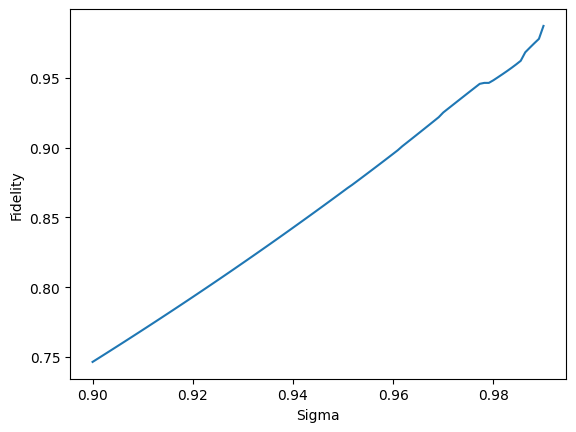

In [6]:
plt.plot(sigmas, fidelities)
plt.xlabel("Sigma")
plt.ylabel("Fidelity")
plt.show()

## Larger Systems

Let us now try this for a slightly larger system, one with 5 qubits compared to the previous 4 qubit system.

In [7]:
Phi_original = jnp.ones(32, dtype=complex)
Phi_original = Phi_original / jnp.linalg.norm(Phi_original)
Phi_spherical = statevector_to_hypersphere(Phi_original)
basis = get_orthonormal_basis(Phi_spherical)  # gives d vectors with d+1 elements each
_, coeffs = get_e2_coeffs(
    d=basis.shape[0],  # gives d coefficients for the d vectors above
    F_j=F_j,
    key=jax.random.PRNGKey(0),
)
e2 = jnp.expand_dims(coeffs, axis=-1) * basis

In [8]:
fidelities = Parallel(n_jobs=4)(delayed(get_fidelity)(sigma) for sigma in sigmas)

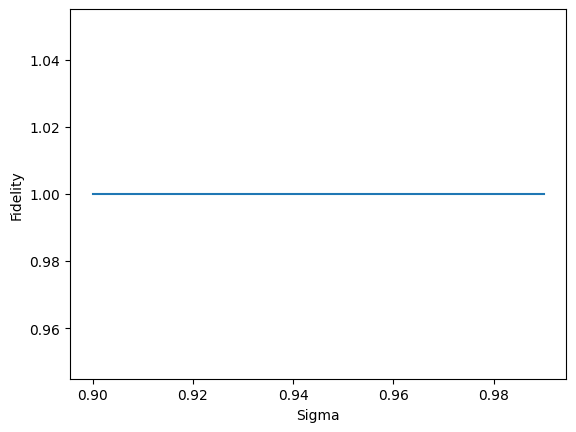

In [9]:
plt.plot(sigmas, fidelities)
plt.xlabel("Sigma")
plt.ylabel("Fidelity")
plt.show()

Unfortunately we see that the fidelity stays close to 0 for all values of sigma when dealing with systems of size 32 and higher. This is currently not explained.